In [ ]:
import tensorflow as tf
import numpy as np

sentence = 'hihello'

voca = set(sentence) # 유일한 글자만 남음
char2idx = {c:i for i,c in enumerate(voca)}
idx2char = {i:c for i,c in enumerate(voca)}
print('char2idx', char2idx)
print('idx2char', idx2char)

x = sentence[:-1]  # 'hihell'
y = sentence[1:] # 'ihello'
print(f'x:{x}, y:{y}')

n_class = len(voca) 
n_time_steps = len(x) # input sequence
hidden_size = n_class # output size

char2idx {'h': 0, 'l': 1, 'e': 2, 'o': 3, 'i': 4}
idx2char {0: 'h', 1: 'l', 2: 'e', 3: 'o', 4: 'i'}
x:hihell, y:ihello


In [ ]:
''' convert char to integer '''
x_idx = [char2idx[c] for c in x]
y_idx = [char2idx[c] for c in y]
print(f'x_idx:{x_idx}, y_idx:{y_idx}')

''' one-hot encoding'''
x_enc = tf.keras.utils.to_categorical(x_idx, num_classes = n_class)     # 2차원 배열로 원핫 인코딩
x_enc = np.expand_dims(x_enc, axis=0) # 차원을 하나 추가 -> 3차원이 됨. shape 가 (1, 6, 5)가 됨.

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print('x_enc:', x_enc, x_enc.shape, )
print('y_enc:', y_enc, y_enc.shape)

x_idx:[0, 4, 0, 2, 1, 1], y_idx:[4, 0, 2, 1, 1, 3]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]] (1, 6, 5)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=True))  # return_sequences를 True로 해야지 hidden state 값이 넘어감
model.add(tf.keras.layers.Dense(hidden_size))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  # sparse_categorical_crossentropy를 하면 숫자로 나옴.
# optimizer를 rmsprop로도 가능하지만 adam이 성능이 좋다
n_epochs = 100
history = model.fit(x_enc, np.reshape(y_idx, (1, 6, 1)), epochs=n_epochs, verbose=0)

preds = model.predict(x_enc)
print(preds, np.squeeze(np.argmax(preds, axis=2)))  # squeeze : 1차원 형태로 줄임.
print([idx2char[i] for i in np.squeeze(np.argmax(preds, axis=2))])   # 0 : 행 방향,  1: 열 방향,  2: 면 방향

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 5)              220       
                                                                 
 dense (Dense)               (None, 6, 5)              30        
                                                                 
 activation (Activation)     (None, 6, 5)              0         
                                                                 
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
[[[0.18344676 0.2352894  0.19068551 0.19492078 0.19565752]
  [0.20793994 0.23578021 0.19953719 0.17970192 0.17704076]
  [0.18445793 0.24122904 0.1980127  0.18940675 0.18689357]
  [0.17376576 0.24800381 0.18378142 0.22704613 0.16740292]
  [0.16257782 0.24912405 0.15422569 0.29565653 0.13841589]
  [0.15794112 0.24423723 0.

In [ ]:
import tensorflow as tf

# corpus : 말뭉치, 말모이
corpus = ['very good nice quality',
          'stop lies',
          'ugly terrible',
          'excellent work',
          'adorable lovely',
          'bad',
          'greate nice']

y_train = [1, 0, 0, 1, 1, 0, 1] # 1: pos, 0 : neg

t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(corpus)
vocab_size = len(t.word_index) + 1
# 출현하는 단어별로 

print(f'vocab_size : {vocab_size}')

X_encoded = t.texts_to_sequences(corpus)
print(f'integer encoded: {X_encoded}')

max_len = max(len(i) for i in X_encoded)
print(f'max_len: {max_len}')

vocab_size : 15
integer encoded: [[2, 3, 1, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 1]]
max_len: 4


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len, padding='post')  # 뒤쪽에다가 붙이는 것이 post, 앞에다 붙이는 것은 pre, truncating: 잘라내기
y_train = np.array(y_train)
print(f'padded: {X_train}')

embd = tf.keras.layers.Embedding(vocab_size, 2, input_length=max_len)
print(f'embedding init : {embd(X_train)[:3]}')

model = tf.keras.Sequential()
model.add(embd)
model.add(tf.keras.layers.Flatten())  # Dense의 입력으로 넣기위함.  Flatten을 하면 1차원으로 바꿔줌.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 출력값이 0과 1 (긍정과 부정) , 여러가지 종류면 softmax
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=500, verbose=0)

print(f'embedding last : {embd(X_train)[:3]}')

padded: [[ 2  3  1  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14  1  0  0]]
embedding init : [[[-1.37788765e-02 -3.44018228e-02]
  [ 3.59191559e-02 -4.55129743e-02]
  [ 4.08287980e-02  2.49656476e-02]
  [ 3.73352431e-02 -2.24908832e-02]]

 [[-3.39338556e-02  4.35443260e-02]
  [-4.17318717e-02  3.32423188e-02]
  [ 1.65435188e-02 -4.97226715e-02]
  [ 1.65435188e-02 -4.97226715e-02]]

 [[ 2.24001706e-05  4.70766090e-02]
  [ 3.50591280e-02  3.83417644e-02]
  [ 1.65435188e-02 -4.97226715e-02]
  [ 1.65435188e-02 -4.97226715e-02]]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 2)              30        
                                                                 
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_2 (Den

[[ 0.55301654 -0.5264595 ]
 [-0.37585008  0.6043836 ]
 [ 0.39469662 -0.4817866 ]
 [-0.40644866  0.3218565 ]
 [ 0.37560725  0.5331475 ]
 [-0.5268005   0.57541555]
 [ 0.48578215 -0.41590923]
 [-0.49090743  0.5770282 ]
 [ 0.5606537  -0.4089089 ]
 [ 0.49154195 -0.49110138]
 [-0.5515986   0.4475175 ]
 [ 0.53824776 -0.48879576]
 [-0.4869719   0.4662715 ]
 [-0.4942172   0.5694502 ]
 [ 0.49325597 -0.5260937 ]]


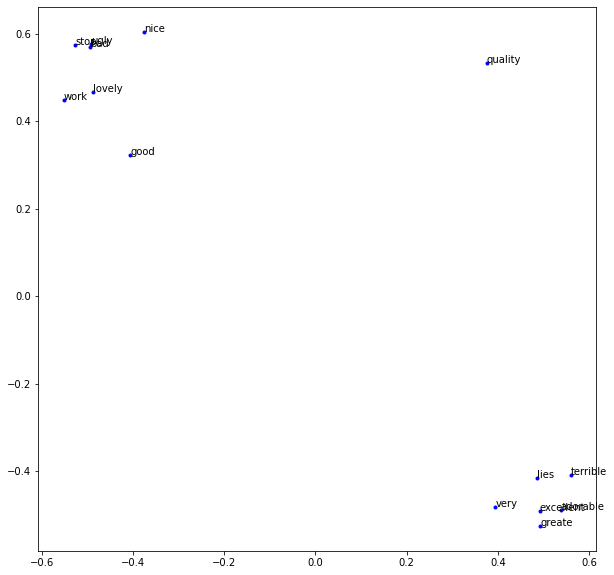

In [ ]:
import matplotlib.pyplot as plt

embd_matrix = embd.get_weights()[0]
print(embd_matrix)
plt.figure(figsize=(10,10))
for idx, (x1, x2) in enumerate(embd_matrix):
  if idx == 0 : continue
  plt.plot(x1, x2, 'b.')
  plt.annotate(t.index_word[idx],(x1, x2 ))